<a href="https://colab.research.google.com/github/lisaong/diec/blob/master/day4/rl/path_finding_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning Path-Finding Demo

This demonstrates how to:
- Use OpenAI gym to create a custom environment
- Compare different Q-learning algorithms for Reinforcement Learning

Inspired by: http://mnemstudio.org/path-finding-q-learning-tutorial.htm

## Problem Setup

Bender is lost in Fry's house! Help Bender find Fry (who is in Room 5 waiting with a can of beer).

![intro](https://github.com/lisaong/diec/raw/master/day4/rl/path_finding_intro.png)

(Character credits: Futurama)

Review these [slides](https://github.com/lisaong/diec/blob/master/day4/rl/some%20intro%20slides.pdf) to see how the problem is formulated as a Q-Learning RL problem.

## OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) is an open-source Python toolkit for developing RL algorithms.

We will use OpenAI gym to re-create Fry's house, then run some reinforcement learning to find the path.

https://github.com/openai/gym/blob/master/docs/creating-environments.md


In [8]:
# gym is already built into Colab
import gym
from gym import spaces
import numpy as np
import random

gym.__version__

'0.17.1'

In [9]:
#
# A Simple Path Finding OpenAI Gym Environment
#
# Inspired by: http://mnemstudio.org/path-finding-q-learning-tutorial.htm
#

import gym
from gym import spaces
import numpy as np
import random

class FrysHomeEnv(gym.Env):
  """Custom Environment describing Fry's home  
  
  For details on the gym.Env class:
  https://github.com/openai/gym/blob/master/gym/core.py
  """

  # render to the current display or terminal
  metadata = {'render.modes': ['human']}

  def __init__(self, rewards):
    super(FrysHomeEnv, self).__init__()

    self.rewards = rewards
    self.num_rooms = self.rewards.shape[0]

    # Action space describes all possible actions that can be taken
    # here, we can select 1 out of 6 rooms
    self.action_space = spaces.Discrete(self.num_rooms)

    # Observation space describes the valid observations
    # since we are moving between rooms, we can be in 1 of 6 rooms
    self.observation_space = spaces.Discrete(self.num_rooms)

    # Rewards range describes the min and max possible rewards
    self.reward_range = (self.rewards.min(), self.rewards.max())

    # Room 5 is our goal
    self.goal = 5

    # Initialise our state
    self.reset()

  def reset(self):
    """Reset the environment to an initial state"""

    # Randomly initialise the state
    self.state = random.randint(0, self.num_rooms-1)

    # Return the observation (same as the state in our case)
    obs = self.state
    return obs

  def step(self, action):
    """Execute one step within the environment"""

    # take the selected action
    prev_state = self.state
    self.state = action

    # calculate the reward
    reward = self.rewards[prev_state][action]

    # check if we've reached our goal
    done = (prev_state == self.goal or self.state == self.goal)

    # get the next observation
    obs = self.state

    return obs, reward, done, {}

  def render(self, mode='human', close=True):
    """Print state of the current environment"""
    print(f'Current room: {self.state}, Reached goal: {self.state == self.goal}')

In [2]:
# Unit testing

# Initialise the rewards matrix for the rooms in the house
# Where:
#  state: current room, action: next room
#  dimensions (row=state, col=actions)
#  A value of -1 means there is no adjacent path from room_i to room_j
#  (for example, room_0 to room_0 has, room_0 to room_5)

R = np.array([[-1, -1, -1, -1,  0, -1 ],
              [-1, -1, -1,  0, -1, 100],
              [-1, -1, -1,  0, -1, -1 ], 
              [-1,  0,  0, -1,  0, -1 ],
              [ 0, -1, -1,  0, -1, 100],
              [-1,  0, -1, -1,  0, 100]])

myenv = FrysHomeEnv(rewards=R)

for i in range(0, 6):
  print(myenv.step(i))
  myenv.render()

(0, -1, False, {})
Current room: 0, Reached goal: False
(1, -1, False, {})
Current room: 1, Reached goal: False
(2, -1, False, {})
Current room: 2, Reached goal: False
(3, 0, False, {})
Current room: 3, Reached goal: False
(4, 0, False, {})
Current room: 4, Reached goal: False
(5, 100, True, {})
Current room: 5, Reached goal: True


## Package custom environment as module

OpenAI gym requires all environments to be packaged as Python modules.

The code above has been packaged here:
https://github.com/lisaong/diec/blob/master/day4/rl/gym-fryshome

The module follows this convention:
https://github.com/openai/gym/blob/master/docs/creating-environments.md

In [10]:
# Restart environment after running this
!pip --no-cache-dir install -e "git+https://github.com/lisaong/diec#egg=gym_fryshome&subdirectory=day4/rl/gym-fryshome"

Obtaining gym_fryshome from git+https://github.com/lisaong/diec#egg=gym_fryshome&subdirectory=day4/rl/gym-fryshome
  Cloning https://github.com/lisaong/diec to .\src\gym-fryshome
  Found existing installation: gym-fryshome 0.0.1
    Uninstalling gym-fryshome-0.0.1:
      Successfully uninstalled gym-fryshome-0.0.1
  Running setup.py develop for gym-fryshome


## ** Restart the Colab kernel after the above pip install**

Runtime -> Restart Runtime

In [11]:
# IMPORTANT: RESTART THE COLAB KERNEL if you've just ran !pip install

# Test the installation
import gym_fryshome

gym_fryshome

<module 'gym_fryshome' from 'd:\\diec\\day4\\rl\\diec\\day4\\rl\\gym-fryshome\\gym_fryshome\\__init__.py'>

## Random Walk Agent
 
The simplest way is to have Bender randomly walk around the house.
* We will run 20 episodes, where each episode is a maximum of 100 steps
* Refer to http://gym.openai.com/docs/

This doesn't actually learn anything, but is a good baseline for any RL agents.

In [12]:
class RandomAgent:
    """The world's simplest agent!
      https://github.com/openai/gym/blob/master/examples/agents/random_agent.py
    """
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done):
        return self.action_space.sample()

In [13]:
import gym
import numpy as np

# Constants
EPISODE_COUNT = 20
STEPS_PER_EPISODE = 100
R = np.array([[-1, -1, -1, -1,  0, -1 ],
              [-1, -1, -1,  0, -1, 100],
              [-1, -1, -1,  0, -1, -1 ], 
              [-1,  0,  0, -1,  0, -1 ],
              [ 0, -1, -1,  0, -1, 100],
              [-1,  0, -1, -1,  0, 100]])
# Global state
done = False
reward = 0

# Create our environment (Fry's home), and our agent
env = gym.make('gym_fryshome:fryshome-v0', rewards=R)
bender_agent = RandomAgent(env.action_space)

for episode in range(EPISODE_COUNT):
  observation = env.reset()

  for t in range(STEPS_PER_EPISODE):
    env.render()
    
    # take a random action
    action = bender_agent.act(observation, reward, done)

    # step the environment using the selected action
    observation, reward, done, info = env.step(action)

    if done:
      print(f'Episode finished after {t+1} timesteps\n')
      done = False # reset for next episode
      break

env.close()

Current room: 0, Reached goal: False
Current room: 0, Reached goal: False
Current room: 2, Reached goal: False
Current room: 3, Reached goal: False
Current room: 2, Reached goal: False
Current room: 3, Reached goal: False
Current room: 2, Reached goal: False
Current room: 0, Reached goal: False
Current room: 1, Reached goal: False
Current room: 1, Reached goal: False
Current room: 0, Reached goal: False
Current room: 3, Reached goal: False
Current room: 2, Reached goal: False
Episode finished after 13 timesteps

Current room: 2, Reached goal: False
Current room: 4, Reached goal: False
Current room: 2, Reached goal: False
Current room: 1, Reached goal: False
Current room: 2, Reached goal: False
Episode finished after 5 timesteps

Current room: 0, Reached goal: False
Current room: 1, Reached goal: False
Current room: 1, Reached goal: False
Episode finished after 3 timesteps

Current room: 3, Reached goal: False
Current room: 0, Reached goal: False
Current room: 3, Reached goal: False
Cur

## Q-Learning Agent

Let's implement the basic Q-Learning formula (without Temporal Differencing):

`Q(state, action) = R(state, action) + gamma * max[Q(next_state, all actions)]`

Our Q-Learning agent will store the Q-values as we go along. This can be thought of as Benders "brain"!

In [16]:
import numpy as np
import random
from gym import spaces

class QLearningAgent:
  """Basic Q-Learning Agent"""
  def __init__(self, rewards, gamma=0.8, verbose=False):
    """rewards: the rewards matrix
    gamma: the discount factor in considering future rewards
    """
    self.rewards = rewards

    # Initialise the Q-matrix to zeros:
    # dimensions (row=state, cols=actions)
    self.Q = np.zeros(rewards.shape)

    self.gamma = gamma
    self.verbose = verbose

  def _get_valid_actions(self, observation):
    actions = np.arange(self.rewards.shape[1])
    return actions[self.rewards[observation] != -1]

  def act(self, observation, reward, done):
    """Update the Q-matrix, then take an action
    observation: current state
    reward: reward from the previous action (unused)
    done: whether the episode is completed
    """
    # randomly select the next action/observation
    valid_actions = self._get_valid_actions(observation)
    action = np.random.choice(valid_actions)

    if not done:
      # find the maximum Q-value for all future actions
      next_observation = action
      all_actions = self._get_valid_actions(next_observation)
      future_rewards = self.Q[next_observation][all_actions]

      print(f'Action: {action}, next state: {next_observation}, \
  all actions: {all_actions}, all future rewards: {future_rewards}, \
  max future reward: {future_rewards.max():.3f}')

      # update the Q matrix
      # Q(state, action) = R(state, action) + gamma * max[Q(next state, all actions)]
      self.Q[observation][action] = self.rewards[observation][action] + \
        self.gamma * future_rewards.max()

      if self.verbose:
        print(f'Q-values:\n{self.Q}')

    return action

  def best_path(self, initial_state, goal=5):
    """Returns the best path starting from a given state"""
    path = [initial_state]
    state = initial_state

    while(True):
      state = self.Q[state].argmax()
      path.append(state)
      if state == goal:
        break
      
    return path          

In [17]:
# Unit Test
test_agent = QLearningAgent(rewards=R, verbose=True)
action = test_agent.act(1, 0, False)

Action: 5, next state: 5,   all actions: [1 4 5], all future rewards: [0. 0. 0.],   max future reward: 0.000
Q-values:
[[  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 100.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]]


Put our agent to work. Hopefully Bender is now smarter.

In [18]:
# Global state
EPISODE_COUNT = 100
STEPS_PER_EPISODE = 20
done = False
reward = 0

# Track how many timesteps it took to finish
history = {start:[] for start in range(R.shape[0])}

# Create our environment (Fry's home), and our new agent
env = gym.make('gym_fryshome:fryshome-v0', rewards=R)
bender_v2 = QLearningAgent(rewards=R)

for episode in range(EPISODE_COUNT):
  observation = env.reset()
  start = observation

  for t in range(STEPS_PER_EPISODE):
    env.render()
    
    # take the next action
    action = bender_v2.act(observation, reward, done)

    # step the environment using the selected action
    observation, reward, done, info = env.step(action)

    if done:
      print(f'Episode finished after {t+1} timesteps\n')
      history[start].append(t+1)
      done = False # reset for next episode
      break

env.close()

om: 3, Reached goal: False
Action: 2, next state: 2,   all actions: [3], all future rewards: [220.123136],   max future reward: 220.123
Current room: 2, Reached goal: False
Action: 3, next state: 3,   all actions: [1 2 4], all future rewards: [275.15392   176.0985088 275.15392  ],   max future reward: 275.154
Current room: 3, Reached goal: False
Action: 4, next state: 4,   all actions: [0 3 5], all future rewards: [220.123136 220.123136 343.9424  ],   max future reward: 343.942
Current room: 4, Reached goal: False
Action: 5, next state: 5,   all actions: [1 4 5], all future rewards: [275.15392 275.15392 304.928  ],   max future reward: 304.928
Episode finished after 9 timesteps

Current room: 3, Reached goal: False
Action: 1, next state: 1,   all actions: [3 5], all future rewards: [220.123136 343.9424  ],   max future reward: 343.942
Current room: 1, Reached goal: False
Action: 3, next state: 3,   all actions: [1 2 4], all future rewards: [275.15392   176.0985088 275.15392  ],   max f

In [26]:
# plot the history as a moving average
import matplotlib.pyplot as plt

def plot_history(history, title):
  def moving_average(a, n):
    # https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

  fig, ax = plt.subplots(figsize=(15, 8))

  window_size = min(EPISODE_COUNT//10, 5)
  for start, ts in history.items():
    ax.plot(moving_average(ts, window_size), label=f'Initial state: {start}')

  ax.set_title(title)
  ax.set_xlabel(f'Number of episodes')
  ax.set_ylabel(f'Moving average (window size: {window_size})')

  ax.legend()
  plt.show()

plot_history(history, title='History (Q-Learning)')

<Figure size 1500x800 with 1 Axes>

In [27]:
bender_v2.Q

array([[  0.       ,   0.       ,   0.       ,   0.       , 275.15392  ,
          0.       ],
       [  0.       ,   0.       ,   0.       , 220.123136 ,   0.       ,
        343.9424   ],
       [  0.       ,   0.       ,   0.       , 220.123136 ,   0.       ,
          0.       ],
       [  0.       , 275.15392  , 176.0985088,   0.       , 275.15392  ,
          0.       ],
       [220.123136 ,   0.       ,   0.       , 220.123136 ,   0.       ,
        343.9424   ],
       [  0.       , 275.15392  ,   0.       ,   0.       , 275.15392  ,
        343.9424   ]])

Now Bender can find the best path to beer from any room!

In [28]:
room_with_beer = 5
for initial_state in range(room_with_beer+1):
  print(bender_v2.best_path(initial_state))

[0, 4, 5]
[1, 5]
[2, 3, 1, 5]
[3, 1, 5]
[4, 5]
[5, 5]


## Q-Learning Agent with TD

A small, but significant, improvement for the Q-Learning Agent is to add Temporal Differencing.  

Strictly speaking, TD is not necessary for this case because all the states and actions are known.

However, TD is good when we don't know all the states and actions in advance, and need some way to estimate the Q-values.

![equation](https://wikimedia.org/api/rest_v1/media/math/render/svg/678cb558a9d59c33ef4810c9618baf34a9577686)

Source: https://en.wikipedia.org/wiki/Q-learning


In [29]:
class QLearningTDAgent(QLearningAgent):
  """Q-Learning Agent with Temporal Differencing"""
  def __init__(self, rewards, gamma=0.8, alpha=0.1, verbose=False):
    """rewards: the rewards matrix
    gamma: the discount factor in considering future rewards
    alpha: how much prior knowledge to include
    """
    super(QLearningTDAgent, self).__init__(rewards, gamma, verbose)
    self.alpha = alpha

  def act(self, observation, reward, done):
    """Update the Q-matrix, then take an action
    observation: current state
    reward: reward from the previous action (unused)
    done: whether the episode is completed
    """
    # randomly select the next action/observation
    valid_actions = self._get_valid_actions(observation)
    action = np.random.choice(valid_actions)

    if not done:
      # find the maximum Q-value for all future actions
      next_observation = action
      all_actions = self._get_valid_actions(next_observation)
      future_rewards = self.Q[next_observation][all_actions]

      print(f'Action: {action}, next state: {next_observation}, \
  all actions: {all_actions}, all future rewards: {future_rewards}, \
  max future reward: {future_rewards.max():.3f}')

      # update the Q matrix
      # this is where temporal difference is applied
      old_value = self.Q[observation][action]
      self.Q[observation][action] = old_value + \
        self.alpha * (self.rewards[observation][action] + \
                      self.gamma * future_rewards.max() - old_value)

      if self.verbose:
        print(f'Q-values:\n{self.Q}')

    return action

In [24]:
# Global state
EPISODE_COUNT = 100
STEPS_PER_EPISODE = 20
done = False
reward = 0

# Track how many timesteps it took to finish
history_v3 = {start:[] for start in range(R.shape[0])}

env = gym.make('gym_fryshome:fryshome-v0', rewards=R)
bender_v3 = QLearningTDAgent(rewards=R)

for episode in range(EPISODE_COUNT):
  observation = env.reset()
  start = observation

  for t in range(STEPS_PER_EPISODE):
    env.render()
    
    # take the next action
    action = bender_v3.act(observation, reward, done)

    # step the environment using the selected action
    observation, reward, done, info = env.step(action)

    if done:
      print(f'Episode finished after {t+1} timesteps\n')
      history_v3[start].append(t+1)
      done = False # reset for next episode
      break

env.close()

ure reward: 79.125
Current room: 0, Reached goal: False
Action: 4, next state: 4,   all actions: [0 3 5], all future rewards: [ 46.85909     46.720264   119.87982675],   max future reward: 119.880
Current room: 4, Reached goal: False
Action: 3, next state: 3,   all actions: [1 2 4], all future rewards: [73.6989728  25.46325558 82.25624868],   max future reward: 82.256
Current room: 3, Reached goal: False
Action: 1, next state: 1,   all actions: [3 5], all future rewards: [ 42.47673429 112.94870643],   max future reward: 112.949
Current room: 1, Reached goal: False
Action: 5, next state: 5,   all actions: [1 4 5], all future rewards: [ 8.6387891  16.47468583 38.81592   ],   max future reward: 38.816
Episode finished after 5 timesteps

Current room: 0, Reached goal: False
Action: 4, next state: 4,   all actions: [0 3 5], all future rewards: [ 46.85909     48.6287375  119.87982675],   max future reward: 119.880
Current room: 4, Reached goal: False
Action: 5, next state: 5,   all actions: 

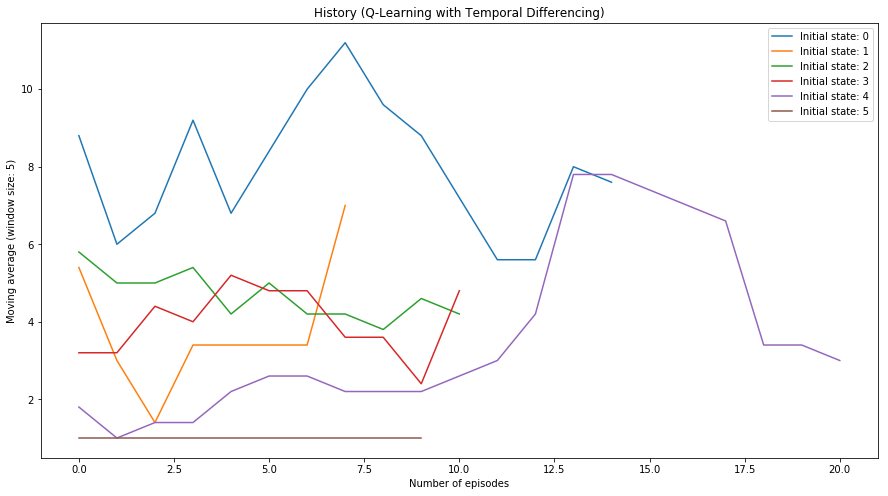

In [30]:
plot_history(history_v3, 'History (Q-Learning with Temporal Differencing)')

In [31]:
bender_v3.Q

array([[  0.        ,   0.        ,   0.        ,   0.        ,
         96.51467668,   0.        ],
       [  0.        ,   0.        ,   0.        ,  60.53292285,
          0.        , 121.76448718],
       [  0.        ,   0.        ,   0.        ,  66.97230362,
          0.        ,   0.        ],
       [  0.        ,  89.57522155,  42.42404494,   0.        ,
         93.25717242,   0.        ],
       [ 64.80696366,   0.        ,   0.        ,  55.74397309,
          0.        , 130.62000723],
       [  0.        ,  31.9607792 ,   0.        ,   0.        ,
         32.50973351,  57.07880957]])

Convergence seems quicker compared to Basic Q-Learning, as noticed by the smaller moving averages. 

Bender V3 learnt a bit quicker than Bender V2.

In [32]:
room_with_beer = 5
for initial_state in range(room_with_beer+1):
  print(bender_v3.best_path(initial_state))

[0, 4, 5]
[1, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5, 5]


## More Advanced Agents

You can install baselines, which contain implementation of more sophisticated agents.

https://github.com/openai/baselines